## Evaluating Model Performance and Analyzing Results

After training, the model is evaluated on the test set. Predictions are generated, and several key metrics–including overall accuracy, weighted precision, and weighted recall–are calculated. A detailed classification report is produced for each class, alongside a confusion matrix visualization to reveal common misclassifications. Finally, a class-wise performance analysis highlights the best and most challenging categories for the model, offering insights into its strengths and weaknesses.

### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import inflect
import re
import string

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import (LabelEncoder, 
                                 StandardScaler)
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

/projectnb/dl4ds/students/annliang/deep-learning-project/.venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [6]:
# Find csv file at https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019/data

df = pd.read_csv('music_data.csv') 
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


### Data Preprocessing

In [7]:
# Select relevant features for the model

topic_df = df[['artist_name','track_name','lyrics','topic']]
topic_df.head()

,artist_name,track_name,lyrics,topic
0,mukesh,mohabbat bhi jhoothi,hold time feel break feel untrue convince spea...,sadness
1,frankie laine,i believe,believe drop rain fall grow believe darkest ni...,world/life
2,johnnie ray,cry,sweetheart send letter goodbye secret feel bet...,music
3,pérez prado,patricia,kiss lips want stroll charm mambo chacha merin...,romantic
4,giorgos papadopoulos,apopse eida oneiro,till darling till matter know till dream live ...,romantic


In [8]:
# Preprocessing function

def preprocess(text):
    p = inflect.engine()

    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Replace numeric tokens with words
    text = re.sub(r'\b\d+\b', lambda match: p.number_to_words(match.group()), text)
    
    # Tokenize words
    tokens = word_tokenize(text)
    
    # Load stopwords
    stop_words = set(stopwords.words("english"))
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize and filter tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    
    return tokens

In [9]:
# Lyrics pre-processing

topic_df['lyric_tokens'] = topic_df['lyrics'].apply(preprocess)
topic_df['lyric_tokens'] = topic_df['lyric_tokens'].apply(lambda tokens: ' '.join(tokens))

# Label encoding 

label_encoder = LabelEncoder()
topic_df['topic_labels'] = label_encoder.fit_transform(topic_df['topic'])

/projectnb/dl4ds/students/annliang/deep-learning-project/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/projectnb/dl4ds/students/annliang/deep-learning-project/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/projectnb/dl4ds/students/annliang/deep-learning-project/.venv/lib

In [10]:
topic_df

,artist_name,track_name,lyrics,topic,lyric_tokens,topic_labels
0,mukesh,mohabbat bhi jhoothi,hold time feel break feel untrue convince spea...,sadness,hold time feel break feel untrue convince spea...,5
1,frankie laine,i believe,believe drop rain fall grow believe darkest ni...,world/life,believe drop rain fall grow believe darkest ni...,7
2,johnnie ray,cry,sweetheart send letter goodbye secret feel bet...,music,sweetheart send letter goodbye secret feel bet...,1
3,pérez prado,patricia,kiss lips want stroll charm mambo chacha merin...,romantic,kiss lip want stroll charm mambo chacha mering...,4
4,giorgos papadopoulos,apopse eida oneiro,till darling till matter know till dream live ...,romantic,till darling till matter know till dream live ...,4
...,...,...,...,...,...,...
28367,mack 10,10 million ways,cause fuck leave scar tick tock clock come kno...,obscene,cause fuck leave scar tick tock clock come kno...,3
28368,m.o.p.,ante up (robbin hoodz theory),minks things chain ring braclets yap fame come...,obscene,mink thing chain ring braclets yap fame come f...,3
28369,nine,whutcha want?,get ban get ban stick crack relax plan attack ...,obscene,get ban get ban stick crack relax plan attack ...,3
28370,will smith,switch,check check yeah yeah hear thing call switch g...,obscene,check check yeah yeah hear thing call switch g...,3


In [11]:
# Create n-gram embeddings 

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Unigrams + bigrams
    max_features=5000,   # Limit feature size
)

X = vectorizer.fit_transform(topic_df['lyric_tokens'])
y = topic_df['topic_labels']

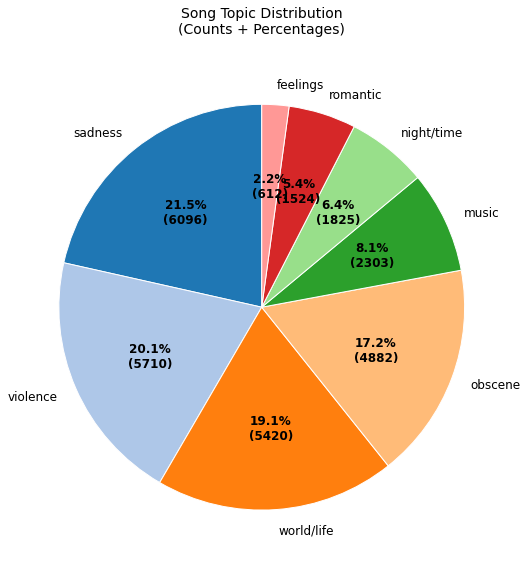

In [12]:
# Get topic counts
topic_counts = topic_df['topic'].value_counts()

# Generate labels with BOTH counts and percentages
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_autopct

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    topic_counts,
    labels=topic_counts.index,
    autopct=make_autopct(topic_counts),
    startangle=90,
    colors=plt.cm.tab20.colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 12}
)

# Style the labels (bold counts)
plt.setp(autotexts, size=12, weight='bold')
plt.title('Song Topic Distribution\n(Counts + Percentages)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# Train test split with 0.2/0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y       # Preserve topic distribution
)

In [14]:
# Get sample counts 
train_samples = X_train.shape[0]  # Correct way for sparse matrices
test_samples = X_test.shape[0]

# Convert numeric labels to text if available
try:
    y_train_text = pd.Series(label_encoder.inverse_transform(y_train))
    y_test_text = pd.Series(label_encoder.inverse_transform(y_test))
except:
    y_train_text = pd.Series(y_train).astype(str) + ' (encoded)'
    y_test_text = pd.Series(y_test).astype(str) + ' (encoded)'

# Create distribution DataFrames
train_dist = y_train_text.value_counts(normalize=True).mul(100).round(2)
test_dist = y_test_text.value_counts(normalize=True).mul(100).round(2)

# Combine into comparison table
dist_df = pd.DataFrame({
    'Train (%)': train_dist,
    'Test (%)': test_dist
}).fillna(0).sort_index()

# Print formatted report
print("="*70)
print(f"{'Data Split Summary':^70}")
print("="*70)
print(f"{'Training set size:':<20}{train_samples:>15,} samples")  # Fixed
print(f"{'Test set size:':<20}{test_samples:>15,} samples\n")     # Fixed

print("-"*70)
print(f"{'Class Distribution Comparison':^70}")
print("-"*70)
print(f"{'Topic':<15}{'Train %':>15}{'Test %':>15}")
print("-"*70)
for idx, row in dist_df.iterrows():
    print(f"{str(idx):<15}{row['Train (%)']:>15.2f}{row['Test (%)']:>15.2f}")
print("="*70)
print("="*70)

                          Data Split Summary                          
Training set size:           22,697 samples
Test set size:                5,675 samples

----------------------------------------------------------------------
                    Class Distribution Comparison                     
----------------------------------------------------------------------
Topic                  Train %         Test %
----------------------------------------------------------------------
feelings                  2.16           2.15
music                     8.12           8.12
night/time                6.43           6.43
obscene                  17.20          17.22
romantic                  5.37           5.37
sadness                  21.49          21.48
violence                 20.13          20.12
world/life               19.10          19.10


In [15]:
# Assume X_train and X_test are sparse matrices
X_train_dense = torch.from_numpy(X_train.toarray()).float()
X_test_dense = torch.from_numpy(X_test.toarray()).float()

# Make sure y's are in tensor format
y_train = torch.from_numpy(y_train.values).long()
y_test = torch.from_numpy(y_test.values).long()

# Create DataLoaders for faster computation
train_dataset = TensorDataset(X_train_dense, y_train)
test_dataset = TensorDataset(X_test_dense, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### Model Training and Testing

In [16]:
# Define NN model 

class LyricClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LyricClassifier, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        return self.model(x)

model = LyricClassifier(input_dim=X_train_dense.shape[1], num_classes=len(torch.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training history storage
history = {
    'train_loss': [],
    'test_loss': [],
    'test_accuracy': []
}

# Training loop
for epoch in range(20):  # Number of epochs
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Test evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss += criterion(outputs, batch_y).item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    # Store metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['test_loss'].append(test_loss / len(test_loader))
    history['test_accuracy'].append(correct / total)
    
    print(f"Epoch {epoch+1}/20 - "
          f"Train Loss: {history['train_loss'][-1]:.4f} - "
          f"Test Loss: {history['test_loss'][-1]:.4f} - "
          f"Test Accuracy: {history['test_accuracy'][-1]:.4f}")

# Final evaluation
final_test_loss = history['test_loss'][-1]
final_test_accuracy = history['test_accuracy'][-1]
print(f"\nFinal Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/20 - Train Loss: 0.5634 - Test Loss: 0.2311 - Test Accuracy: 0.9218
Epoch 2/20 - Train Loss: 0.0868 - Test Loss: 0.2508 - Test Accuracy: 0.9198
Epoch 3/20 - Train Loss: 0.0273 - Test Loss: 0.2827 - Test Accuracy: 0.9193
Epoch 4/20 - Train Loss: 0.0133 - Test Loss: 0.2998 - Test Accuracy: 0.9209
Epoch 5/20 - Train Loss: 0.0099 - Test Loss: 0.3305 - Test Accuracy: 0.9223
Epoch 6/20 - Train Loss: 0.0085 - Test Loss: 0.4011 - Test Accuracy: 0.9140
Epoch 7/20 - Train Loss: 0.0075 - Test Loss: 0.3971 - Test Accuracy: 0.9156
Epoch 8/20 - Train Loss: 0.0096 - Test Loss: 0.5171 - Test Accuracy: 0.8987
Epoch 9/20 - Train Loss: 0.0225 - Test Loss: 0.5115 - Test Accuracy: 0.9033
Epoch 10/20 - Train Loss: 0.0106 - Test Loss: 0.5125 - Test Accuracy: 0.9089
Epoch 11/20 - Train Loss: 0.0069 - Test Loss: 0.5214 - Test Accuracy: 0.9063
Epoch 12/20 - Train Loss: 0.0042 - Test Loss: 0.5534 - Test Accuracy: 0.9045
Epoch 13/20 - Train Loss: 0.0034 - Test Loss: 0.5346 - Test Accuracy: 0.9084
Epoch 14

### Model Evaluation

                  MODEL PERFORMANCE REPORT                  
Overall Accuracy:   0.9010
Weighted Precision: 0.9017
Weighted Recall:    0.9010
------------------------------------------------------------

Detailed Classification Report:


/projectnb/dl4ds/students/annliang/deep-learning-project/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


              precision    recall  f1-score   support

    feelings     0.8482    0.7787    0.8120       122
       music     0.9019    0.9176    0.9097       461
  night/time     0.8606    0.8795    0.8699       365
     obscene     0.9377    0.9089    0.9231       977
    romantic     0.9175    0.8754    0.8960       305
     sadness     0.9112    0.9089    0.9101      1219
    violence     0.9066    0.8757    0.8909      1142
  world/life     0.8686    0.9327    0.8995      1084

    accuracy                         0.9010      5675
   macro avg     0.8940    0.8847    0.8889      5675
weighted avg     0.9017    0.9010    0.9009      5675



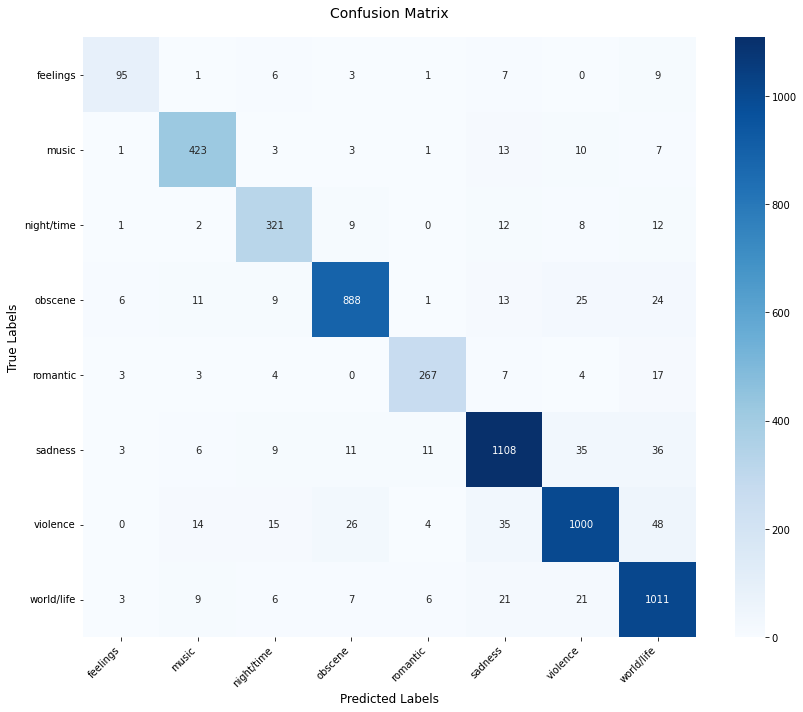


Class-wise Performance Metrics:
              precision  recall  f1-score  accuracy   support
feelings         0.8482  0.7787    0.8120    0.7787   122.000
music            0.9019  0.9176    0.9097    0.9176   461.000
night/time       0.8606  0.8795    0.8699    0.8795   365.000
obscene          0.9377  0.9089    0.9231    0.9089   977.000
romantic         0.9175  0.8754    0.8960    0.8754   305.000
sadness          0.9112  0.9089    0.9101    0.9089  1219.000
violence         0.9066  0.8757    0.8909    0.8757  1142.000
world/life       0.8686  0.9327    0.8995    0.9327  1084.000
accuracy         0.9010  0.9010    0.9010       NaN     0.901
macro avg        0.8940  0.8847    0.8889       NaN  5675.000
weighted avg     0.9017  0.9010    0.9009       NaN  5675.000

                        KEY FINDINGS                        
Best Performing Class: world/life (Accuracy: 93.27%)
Most Challenging Class: feelings (Accuracy: 77.87%)
Most Frequent Confusion: violence → world/life


In [17]:
# Ensure model is in eval mode
model.eval()

# Generate predictions on test set
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test_dense, dtype=torch.float32))
    _, y_pred = torch.max(test_outputs, 1)
    y_true = y_test

# Convert tensors to numpy arrays
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

# Get class names
class_names = label_encoder.classes_

# 1. Overall Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print("="*60)
print(f"{'MODEL PERFORMANCE REPORT':^60}")
print("="*60)
print(f"{'Overall Accuracy:':<20}{accuracy:.4f}")
print(f"{'Weighted Precision:':<20}{precision:.4f}")
print(f"{'Weighted Recall:':<20}{recall:.4f}")
print("-"*60)

# 2. Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# 3. Confusion Matrix Visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Class-wise Performance DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

# Calculate class-wise accuracy
class_accuracies = []
for class_idx in range(len(class_names)):
    mask = y_true == class_idx
    class_accuracies.append((y_pred[mask] == class_idx).mean())

report_df['accuracy'] = pd.Series(class_accuracies, index=class_names)

print("\nClass-wise Performance Metrics:")
print(report_df[['precision', 'recall', 'f1-score', 'accuracy', 'support']].round(4))

# 5. Key Findings
print("\n" + "="*60)
print(f"{'KEY FINDINGS':^60}")
print("="*60)
best_class = report_df['accuracy'].idxmax()
worst_class = report_df['accuracy'].idxmin()
print(f"Best Performing Class: {best_class} (Accuracy: {report_df.loc[best_class, 'accuracy']:.2%})")
print(f"Most Challenging Class: {worst_class} (Accuracy: {report_df.loc[worst_class, 'accuracy']:.2%})")

if len(class_names) <= 20:
    most_confused = pd.DataFrame(cm, index=class_names, columns=class_names)
    most_confused.values[np.diag_indices_from(most_confused)] = 0
    top_confusion = most_confused.stack().idxmax()
    print(f"Most Frequent Confusion: {top_confusion[0]} → {top_confusion[1]}")
print("="*60)